## **GPU**

In [1]:
!nvidia-smi

Mon Aug  5 11:42:53 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.01    Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   62C    P8     3W /  N/A |    121MiB /  4096MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Imports 📢**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm
from prettytable import PrettyTable

# **Dataset 🗂️**

## Read Dataset

In [6]:
!unrar x ./data/data.rar -d ./data/
!cp ./data/data/X.csv ./data/
!cp ./data/data/y.csv ./data/
!rm -r ./data/data/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from ./data/data.rar

Creating    ./data/data                                               OK
Extracting  ./data/data/X.csv                                           68  OK 
Extracting  ./data/data/y.csv                                           98  OK 
All OK


In [7]:
X = pd.read_csv('./data/X.csv', header=None)
y = pd.read_csv('./data/y.csv', header=None)

## DataSplit

In [8]:
num_samples = 327
train_ratio = 0.8
random_seed = 42

torch.manual_seed(random_seed)
train_size = int(num_samples * train_ratio)
x_train, y_train = X[:train_size], y[:train_size]
x_val, y_val = X[train_size: train_size + 33], y[train_size: train_size + 33]
x_test, y_test = X[train_size + 33:], y[train_size + 33:]

## PreProcess

In [9]:
# Convert to tensor
x_train = (torch.FloatTensor(x_train.values)).unsqueeze(dim=2)
y_train = torch.LongTensor(y_train.values)

x_val = (torch.FloatTensor(x_val.values)).unsqueeze(dim=2)
y_val = torch.LongTensor(y_val.values)

x_test = (torch.FloatTensor(x_test.values)).unsqueeze(dim=2)
y_test = torch.LongTensor(y_test.values)

In [10]:
def MinMaxScale(data, min, max):
    return (data - min) / (max - min)

x_min = torch.min(x_train, dim=0).values
x_max = torch.max(x_train, dim=0).values

y_min = torch.min(y_train, dim=0).values
y_max = torch.max(y_train, dim=0).values

x_train = MinMaxScale(x_train, x_min, x_max)
x_val = MinMaxScale(x_val, x_min, x_max)
x_test = MinMaxScale(x_test, x_min, x_max)

y_train = MinMaxScale(y_train, y_min, y_max)
y_val = MinMaxScale(y_val, y_min, y_max)
y_test = MinMaxScale(y_test, y_min, y_max)

In [11]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([261, 5, 1]) torch.Size([33, 5, 1]) torch.Size([33, 5, 1])
torch.Size([261, 1]) torch.Size([33, 1]) torch.Size([33, 1])


## DataLoader

In [12]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [13]:
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, y_batch.shape)

torch.Size([10, 5, 1]) torch.Size([10, 1])


# **Model 🧠**

## Custom Model

In [14]:
class RNNModel(nn.Module):
  def __init__(self, RNN, input_size, hidden_size, num_layers, batch_first, bidirectional, out_feature):
    super().__init__()
    self.rnn = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, bidirectional=bidirectional)
    self.fc = nn.LazyLinear(out_feature)

  def forward(self, x):
    outputs, hn = self.rnn(x)
    outputs = outputs.flatten(1)
    y = self.fc(outputs) # many to many

    return y

## RNN

In [15]:
rnn = RNNModel(nn.RNN, 1, 4, 1, True, False, 1)
print(rnn)
print(rnn(x_batch).shape)

RNNModel(
  (rnn): RNN(1, 4, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=1, bias=True)
)
torch.Size([10, 1])


/home/yousef/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## LSTM

In [16]:
lstm = RNNModel(nn.LSTM, 1, 4, 1, True, False, 1)
print(lstm)
print(lstm(x_batch).shape)

RNNModel(
  (rnn): LSTM(1, 4, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=1, bias=True)
)
torch.Size([10, 1])


## GRU

In [17]:
gru = RNNModel(nn.GRU, 1, 4, 1, True, False, 1)
print(gru)
print(gru(x_batch).shape)

RNNModel(
  (rnn): GRU(1, 4, batch_first=True)
  (fc): LazyLinear(in_features=0, out_features=1, bias=True)
)
torch.Size([10, 1])


## CNNLSTM

In [18]:
class CNNLSTM(nn.Module):

  def __init__(self, input_size, cnn_hidden_size, rnn_hidden_size, num_layers, out_feature):
    super().__init__()

    self.conv1 = nn.Conv1d(input_size, cnn_hidden_size, kernel_size=2, stride=1)
    self.bn1 = nn.BatchNorm1d(cnn_hidden_size)

    self.lstm = nn.LSTM(cnn_hidden_size, rnn_hidden_size, num_layers)

    self.fc = nn.LazyLinear(out_feature)

  def forward(self, x):
    x = x.permute(0, 2, 1)
    y = self.bn1(self.conv1(x)).relu()

    y = y.permute(0, 2, 1)
    y, _ = self.lstm(x)
    y = self.fc(y)
    return y.mean(dim=1)

In [19]:
model = CNNLSTM(1, 5, 4, 1, 1)
model(x_batch).shape

torch.Size([10, 1])

## GRU From Scratch

In [20]:
class Gate(nn.Module):
  def __init__(self, hidden_size, af):
    super().__init__()
    self.fcx = nn.LazyLinear(hidden_size)
    self.fch = nn.LazyLinear(hidden_size)
    self.af = nn.Sigmoid() if af == 'sigmoid' else nn.Tanh()

  def forward(self, x, h):
    return self.af(self.fcx(x)+self.fch(h))

mygate = Gate(4, 'tanh')
mygate

mygate(torch.randn(3, 4), torch.randn(3, 8)).shape

torch.Size([3, 4])

In [21]:
class GRU(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.reset_gate = Gate(hidden_size, 'sigmoid')
    self.update_gate = Gate(hidden_size, 'sigmoid')
    self.candidate_hidden_state = Gate(hidden_size, 'tanh')

  def forward(self, x):
    ht = torch.zeros(self.hidden_size)
    output = []

    for xt in x:
      rt = self.reset_gate(xt, ht)
      rht = rt * ht
      #
      h_tilda = self.candidate_hidden_state(xt, rht)
      #
      zt = self.update_gate(xt, ht)
      ht = zt * ht + (1-zt) * h_tilda
      output.append(ht)
    return output, ht

In [22]:
gru = GRU(4)
gru

GRU(
  (reset_gate): Gate(
    (fcx): LazyLinear(in_features=0, out_features=4, bias=True)
    (fch): LazyLinear(in_features=0, out_features=4, bias=True)
    (af): Sigmoid()
  )
  (update_gate): Gate(
    (fcx): LazyLinear(in_features=0, out_features=4, bias=True)
    (fch): LazyLinear(in_features=0, out_features=4, bias=True)
    (af): Sigmoid()
  )
  (candidate_hidden_state): Gate(
    (fcx): LazyLinear(in_features=0, out_features=4, bias=True)
    (fch): LazyLinear(in_features=0, out_features=4, bias=True)
    (af): Tanh()
  )
)

### Test GRU

In [23]:
output, ht = gru(torch.randn(8, 10))
print(len(output))
print(output[0].shape)

8
torch.Size([4])


# **Device ⚙️**

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RNNModel(nn.RNN, 1, 4, 1, True, False, 1).to(device)

# **Loss & Optimizer ⚖️**

In [25]:
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **Utils 🧰**

In [26]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [27]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [28]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss_valid.update(loss.item())
  return loss_valid.avg

# **Efficient way for set hyperparams 🔨**

You should do this part for all models(RNN,LSTM,GRU,CNNLSTM) and save their results.

## Step 1: check forward path

Calculate loss for one batch

## RNN Model

In [29]:
model = RNNModel(nn.RNN, 1, 4, 1, True, False, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

/home/yousef/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(0.1379, device='cuda:0', grad_fn=<MeanBackward0>)


## LSTM Model

In [30]:
model = RNNModel(nn.LSTM, 1, 4, 1, True, False, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.1034, device='cuda:0', grad_fn=<MeanBackward0>)


## GRU Model

In [31]:
model = RNNModel(nn.GRU, 1, 4, 1, True, False, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.1628, device='cuda:0', grad_fn=<MeanBackward0>)


## CNNLSTM Model

In [32]:
model = CNNLSTM(1, 5, 4, 1, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(0.0406, device='cuda:0', grad_fn=<MeanBackward0>)


/home/yousef/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


## Step 2: check backward path

Select 5 random batches and train the model

In [33]:
_, mini_train_dataset = random_split(train_dataset, (len(train_dataset) - 64, 64))
mini_train_loader = DataLoader(mini_train_dataset, 8)

# RNN, LSTM, GRU

In [34]:
model = RNNModel(nn.RNN, 1, 4, 1, True, False, 1).to(device)
loss_fn = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
  model, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 103.11batch/s, loss=0.0907]


In [35]:
model = RNNModel(nn.LSTM, 1, 4, 1, True, False, 1).to(device)
loss_fn = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
  model, _= train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 65.89batch/s, loss=0.0753]


In [36]:
model = RNNModel(nn.GRU, 1, 4, 1, True, False, 1).to(device)
loss_fn = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
  model, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 0:   0%|          | 0/8 [00:00<?, ?batch/s, loss=0.194]

Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 116.27batch/s, loss=0.0653]


# CNNLSTM

In [37]:
model = CNNLSTM(1, 5, 4, 1, 1).to(device)
loss_fn = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10

for epoch in range(num_epochs):
  model, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 0:   0%|          | 0/8 [00:00<?, ?batch/s]

Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 100.65batch/s, loss=0.0416]


## Step 3: select best lr

Train all data for 3 epochs

# RNN, LSTM, GRU

In [38]:
# RNN, LSTM, GRU
num_epochs = 3

for mdl in [nn.RNN, nn.LSTM, nn.GRU]:
  print(f'model={mdl}')
  for lr in [0.01, 0.001, 0.0015, 0.0001]:
    print(f'LR={lr}')
    model = RNNModel(mdl, 1, 4, 1, True, False, 1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
      model, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()


model=<class 'torch.nn.modules.rnn.RNN'>
LR=0.01


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 103.49batch/s, loss=0.0814]



LR=0.001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 114.68batch/s, loss=0.0861]



LR=0.0015


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 113.06batch/s, loss=0.0756]



LR=0.0001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 81.28batch/s, loss=0.0752]



model=<class 'torch.nn.modules.rnn.LSTM'>
LR=0.01


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 106.07batch/s, loss=0.0865]



LR=0.001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 101.10batch/s, loss=0.0852]



LR=0.0015


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 112.08batch/s, loss=0.0926]



LR=0.0001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 114.60batch/s, loss=0.0837]



model=<class 'torch.nn.modules.rnn.GRU'>
LR=0.01


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 91.30batch/s, loss=0.0753] 



LR=0.001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 106.10batch/s, loss=0.0796]



LR=0.0015


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 112.11batch/s, loss=0.0783]



LR=0.0001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 106.83batch/s, loss=0.0926]

# CNNLSTM

In [39]:
# CNNLSTM
num_epochs = 3

print()
for lr in [0.01, 0.001, 0.0015, 0.0001]:
    print(f'Model: CNNLSTM, LR={lr}')
    model = CNNLSTM(1, 5, 4, 1, 1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
      model, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()


Model: CNNLSTM, LR=0.01


Epoch 0:   0%|          | 0/27 [00:00<?, ?batch/s]

Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 81.19batch/s, loss=0.461]



Model: CNNLSTM, LR=0.001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 116.06batch/s, loss=0.0858]



Model: CNNLSTM, LR=0.0015


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 107.29batch/s, loss=0.207]



Model: CNNLSTM, LR=0.0001


Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 81.82batch/s, loss=0.472]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



# RNN, LSTM, GRU

In [40]:
num_epochs = 5

my_table = PrettyTable([ "Model", "Learning Rate", "Weight decay", "loss"])


for RNN in [nn.RNN, nn.LSTM, nn.GRU]:
  print(f'model={RNN}')
  for lr in [0.01, 0.001, 0.0015, 0.0001]:
    for wd in [0., 1e-4, 1e-5]:

      model = RNNModel(RNN, 1, 4, 1, True, False, 1).to(device)
      optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

      print(f'LR={lr}, WD={wd}')
      for epoch in range(5):
        model, loss = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

        if epoch == 4:
          my_table.add_row([RNN, lr, wd, f'{loss:.4f}'])

      print()

  my_table.add_row([20*'-', 20*'-', 20*'-', 20*'-'])

print(my_table)



model=<class 'torch.nn.modules.rnn.RNN'>
LR=0.01, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 109.94batch/s, loss=0.0538]



LR=0.01, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 112.30batch/s, loss=0.0464]



LR=0.01, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 117.72batch/s, loss=0.0807]



LR=0.001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 87.78batch/s, loss=0.105] 



LR=0.001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 111.65batch/s, loss=0.0962]



LR=0.001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 102.15batch/s, loss=0.0697]



LR=0.0015, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 100.69batch/s, loss=0.086] 



LR=0.0015, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 117.93batch/s, loss=0.0817]



LR=0.0015, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 108.61batch/s, loss=0.0906]



LR=0.0001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 102.01batch/s, loss=0.075] 



LR=0.0001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 96.86batch/s, loss=0.183] 



LR=0.0001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 85.11batch/s, loss=0.316]



model=<class 'torch.nn.modules.rnn.LSTM'>
LR=0.01, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 110.19batch/s, loss=0.0931]



LR=0.01, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 116.10batch/s, loss=0.0947]



LR=0.01, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 106.43batch/s, loss=0.0739]



LR=0.001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 117.11batch/s, loss=0.0773]



LR=0.001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 107.26batch/s, loss=0.0838]



LR=0.001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 98.88batch/s, loss=0.0981] 



LR=0.0015, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 88.95batch/s, loss=0.0978]



LR=0.0015, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 88.13batch/s, loss=0.0828]



LR=0.0015, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 93.34batch/s, loss=0.0736]



LR=0.0001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 98.75batch/s, loss=0.257] 



LR=0.0001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 118.55batch/s, loss=0.235]



LR=0.0001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 76.34batch/s, loss=0.352]



model=<class 'torch.nn.modules.rnn.GRU'>
LR=0.01, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 111.89batch/s, loss=0.0623]



LR=0.01, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 98.33batch/s, loss=0.05]   



LR=0.01, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 99.79batch/s, loss=0.0497]



LR=0.001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 93.97batch/s, loss=0.0874]



LR=0.001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 117.54batch/s, loss=0.0888]



LR=0.001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 110.42batch/s, loss=0.0654]



LR=0.0015, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 107.36batch/s, loss=0.0802]



LR=0.0015, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 86.19batch/s, loss=0.0785]



LR=0.0015, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 105.95batch/s, loss=0.0786]



LR=0.0001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 96.10batch/s, loss=0.0731] 



LR=0.0001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 95.22batch/s, loss=0.1]   



LR=0.0001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 90.75batch/s, loss=0.088] 


+-------------------------------------+----------------------+----------------------+----------------------+
|                Model                |    Learning Rate     |     Weight decay     |         loss         |
+-------------------------------------+----------------------+----------------------+----------------------+
|  <class 'torch.nn.modules.rnn.RNN'> |         0.01         |         0.0          |        0.0538        |
|  <class 'torch.nn.modules.rnn.RNN'> |         0.01         |        0.0001        |        0.0464        |
|  <class 'torch.nn.modules.rnn.RNN'> |         0.01         |        1e-05         |        0.0807        |
|  <class 'torch.nn.modules.rnn.RNN'> |        0.001         |         0.0          |        0.1050        |
|  <class 'torch.nn.modules.rnn.RNN'> |        0.001         |        0.0001        |        0.0962        |
|  <class 'torch.nn.modules.rnn.RNN'> |        0.001         |        1e-05         |        0.0697        |
|  <class 'torch.n

# CNNLSTM

In [41]:
num_epochs = 5

my_table = PrettyTable(["Learning Rate", "Weight decay", "loss"])

for lr in [0.001, 0.0015, 0.0001]:
    for wd in [0., 1e-4, 1e-5]:

      model = CNNLSTM(1, 5, 4, 1, 1).to(device)
      optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

      print(f'LR={lr}, WD={wd}')
      for epoch in range(5):
        model, loss = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

        if epoch == 4:
          my_table.add_row([lr, wd, f'{loss:.4f}'])

      print()

print(my_table)

LR=0.001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 78.51batch/s, loss=0.178]



LR=0.001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 104.03batch/s, loss=0.138]



LR=0.001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 105.73batch/s, loss=0.0783]



LR=0.0015, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 108.12batch/s, loss=0.0883]



LR=0.0015, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 99.24batch/s, loss=0.118] 



LR=0.0015, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 109.02batch/s, loss=0.0852]



LR=0.0001, WD=0.0


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 78.75batch/s, loss=0.111]



LR=0.0001, WD=0.0001


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 98.63batch/s, loss=0.112]



LR=0.0001, WD=1e-05


Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 90.28batch/s, loss=0.163]


+---------------+--------------+--------+
| Learning Rate | Weight decay |  loss  |
+---------------+--------------+--------+
|     0.001     |     0.0      | 0.1775 |
|     0.001     |    0.0001    | 0.1377 |
|     0.001     |    1e-05     | 0.0783 |
|     0.0015    |     0.0      | 0.0883 |
|     0.0015    |    0.0001    | 0.1181 |
|     0.0015    |    1e-05     | 0.0852 |
|     0.0001    |     0.0      | 0.1107 |
|     0.0001    |    0.0001    | 0.1123 |
|     0.0001    |    1e-05     | 0.1626 |
+---------------+--------------+--------+


Model    | RNN      | LSTM    | GRU       | ‫‪CNNLSTM‬‬
---------|----------|---------|-----------|-------------  
best lr  | 0.01   |  0.01   |  0.01   | 0.0015
---------|----------|---------|-----------|-------------  
wd       | 1e-05    |  1e-5   |  1e-05    | 1e-05

## Step 5: train more epochs

# train CNNLSTM

In [42]:
model = CNNLSTM(1, 5, 4, 1, 1).to(device)

In [43]:
lr = 0.0015    # cnnlstm
wd = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.L1Loss()

In [44]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [45]:
num_epochs = 80

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid = validation(model,
                          test_loader,
                          loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  print(f'Valid: Loss = {loss_valid:.4}')

  if loss_valid < best_loss_valid:

    torch.save(model, './model/cnnlstm-model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1

torch.save(torch.tensor(loss_train_hist), f'./model/cnnlstm-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'./model/cnnlstm-loss-valid.pt')

Epoch 0: 100%|██████████| 27/27 [00:00<00:00, 81.90batch/s, loss=0.128]


Valid: Loss = 0.7641
Model Saved!



Epoch 1: 100%|██████████| 27/27 [00:00<00:00, 99.47batch/s, loss=0.0813] 


Valid: Loss = 0.7196
Model Saved!



Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 90.44batch/s, loss=0.0812] 


Valid: Loss = 0.6978
Model Saved!



Epoch 3: 100%|██████████| 27/27 [00:00<00:00, 77.57batch/s, loss=0.0782]


Valid: Loss = 0.6735
Model Saved!



Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 93.54batch/s, loss=0.0734]


Valid: Loss = 0.6362
Model Saved!



Epoch 5: 100%|██████████| 27/27 [00:00<00:00, 88.24batch/s, loss=0.067] 


Valid: Loss = 0.586
Model Saved!



Epoch 6: 100%|██████████| 27/27 [00:00<00:00, 107.63batch/s, loss=0.0589]


Valid: Loss = 0.5272
Model Saved!



Epoch 7: 100%|██████████| 27/27 [00:00<00:00, 99.57batch/s, loss=0.0521] 


Valid: Loss = 0.4713
Model Saved!



Epoch 8: 100%|██████████| 27/27 [00:00<00:00, 92.79batch/s, loss=0.0477]


Valid: Loss = 0.4314
Model Saved!



Epoch 9: 100%|██████████| 27/27 [00:00<00:00, 95.46batch/s, loss=0.0462]


Valid: Loss = 0.4088
Model Saved!



Epoch 10: 100%|██████████| 27/27 [00:00<00:00, 91.96batch/s, loss=0.0452]


Valid: Loss = 0.4025
Model Saved!



Epoch 11: 100%|██████████| 27/27 [00:00<00:00, 100.71batch/s, loss=0.0445]


Valid: Loss = 0.3972
Model Saved!



Epoch 12: 100%|██████████| 27/27 [00:00<00:00, 99.57batch/s, loss=0.0439]


Valid: Loss = 0.3912
Model Saved!



Epoch 13: 100%|██████████| 27/27 [00:00<00:00, 97.35batch/s, loss=0.0434]


Valid: Loss = 0.3847
Model Saved!



Epoch 14: 100%|██████████| 27/27 [00:00<00:00, 105.86batch/s, loss=0.0428]


Valid: Loss = 0.3787
Model Saved!



Epoch 15: 100%|██████████| 27/27 [00:00<00:00, 89.25batch/s, loss=0.0422] 


Valid: Loss = 0.374
Model Saved!



Epoch 16: 100%|██████████| 27/27 [00:00<00:00, 107.54batch/s, loss=0.0419]


Valid: Loss = 0.3689
Model Saved!



Epoch 17: 100%|██████████| 27/27 [00:00<00:00, 86.46batch/s, loss=0.0415]


Valid: Loss = 0.3636
Model Saved!



Epoch 18: 100%|██████████| 27/27 [00:00<00:00, 95.66batch/s, loss=0.0409]


Valid: Loss = 0.3575
Model Saved!



Epoch 19: 100%|██████████| 27/27 [00:00<00:00, 114.01batch/s, loss=0.0405]


Valid: Loss = 0.3508
Model Saved!



Epoch 20: 100%|██████████| 27/27 [00:00<00:00, 98.58batch/s, loss=0.0401]


Valid: Loss = 0.3434
Model Saved!



Epoch 21: 100%|██████████| 27/27 [00:00<00:00, 92.14batch/s, loss=0.0397] 


Valid: Loss = 0.3359
Model Saved!



Epoch 22: 100%|██████████| 27/27 [00:00<00:00, 87.43batch/s, loss=0.0391]


Valid: Loss = 0.3274
Model Saved!



Epoch 23: 100%|██████████| 27/27 [00:00<00:00, 104.54batch/s, loss=0.0388]


Valid: Loss = 0.3198
Model Saved!



Epoch 24: 100%|██████████| 27/27 [00:00<00:00, 103.97batch/s, loss=0.0382]


Valid: Loss = 0.3132
Model Saved!



Epoch 25: 100%|██████████| 27/27 [00:00<00:00, 102.45batch/s, loss=0.0379]


Valid: Loss = 0.3078
Model Saved!



Epoch 26: 100%|██████████| 27/27 [00:00<00:00, 102.46batch/s, loss=0.0376]


Valid: Loss = 0.3085



Epoch 27: 100%|██████████| 27/27 [00:00<00:00, 98.09batch/s, loss=0.0374]


Valid: Loss = 0.3011
Model Saved!



Epoch 28: 100%|██████████| 27/27 [00:00<00:00, 92.63batch/s, loss=0.0369]


Valid: Loss = 0.298
Model Saved!



Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 83.15batch/s, loss=0.0367]


Valid: Loss = 0.2958
Model Saved!



Epoch 30: 100%|██████████| 27/27 [00:00<00:00, 86.34batch/s, loss=0.0362]


Valid: Loss = 0.2922
Model Saved!



Epoch 31: 100%|██████████| 27/27 [00:00<00:00, 87.28batch/s, loss=0.0361]


Valid: Loss = 0.2891
Model Saved!



Epoch 32: 100%|██████████| 27/27 [00:00<00:00, 88.13batch/s, loss=0.0356]


Valid: Loss = 0.2857
Model Saved!



Epoch 33: 100%|██████████| 27/27 [00:00<00:00, 89.22batch/s, loss=0.0352]


Valid: Loss = 0.2812
Model Saved!



Epoch 34: 100%|██████████| 27/27 [00:00<00:00, 85.00batch/s, loss=0.0351]


Valid: Loss = 0.2803
Model Saved!



Epoch 35: 100%|██████████| 27/27 [00:00<00:00, 86.11batch/s, loss=0.0343]


Valid: Loss = 0.2808



Epoch 36: 100%|██████████| 27/27 [00:00<00:00, 96.29batch/s, loss=0.0346]


Valid: Loss = 0.2734
Model Saved!



Epoch 37: 100%|██████████| 27/27 [00:00<00:00, 100.88batch/s, loss=0.0347]


Valid: Loss = 0.2703
Model Saved!



Epoch 38: 100%|██████████| 27/27 [00:00<00:00, 81.60batch/s, loss=0.0339]


Valid: Loss = 0.2659
Model Saved!



Epoch 39: 100%|██████████| 27/27 [00:00<00:00, 95.43batch/s, loss=0.0337]


Valid: Loss = 0.2609
Model Saved!



Epoch 40: 100%|██████████| 27/27 [00:00<00:00, 89.93batch/s, loss=0.0335]


Valid: Loss = 0.2569
Model Saved!



Epoch 41: 100%|██████████| 27/27 [00:00<00:00, 84.34batch/s, loss=0.0328]


Valid: Loss = 0.2579



Epoch 42: 100%|██████████| 27/27 [00:00<00:00, 105.69batch/s, loss=0.0328]


Valid: Loss = 0.2553
Model Saved!



Epoch 43: 100%|██████████| 27/27 [00:00<00:00, 100.31batch/s, loss=0.0332]


Valid: Loss = 0.2488
Model Saved!



Epoch 44: 100%|██████████| 27/27 [00:00<00:00, 94.73batch/s, loss=0.0327] 


Valid: Loss = 0.2406
Model Saved!



Epoch 45: 100%|██████████| 27/27 [00:00<00:00, 101.44batch/s, loss=0.0321]


Valid: Loss = 0.2406
Model Saved!



Epoch 46: 100%|██████████| 27/27 [00:00<00:00, 97.20batch/s, loss=0.032]  


Valid: Loss = 0.2383
Model Saved!



Epoch 47: 100%|██████████| 27/27 [00:00<00:00, 109.63batch/s, loss=0.0322]


Valid: Loss = 0.2294
Model Saved!



Epoch 48: 100%|██████████| 27/27 [00:00<00:00, 88.66batch/s, loss=0.032] 


Valid: Loss = 0.2223
Model Saved!



Epoch 49: 100%|██████████| 27/27 [00:00<00:00, 100.56batch/s, loss=0.0315]


Valid: Loss = 0.223



Epoch 50: 100%|██████████| 27/27 [00:00<00:00, 104.02batch/s, loss=0.0313]


Valid: Loss = 0.2224



Epoch 51: 100%|██████████| 27/27 [00:00<00:00, 90.26batch/s, loss=0.0313]


Valid: Loss = 0.2154
Model Saved!



Epoch 52: 100%|██████████| 27/27 [00:00<00:00, 100.01batch/s, loss=0.031] 


Valid: Loss = 0.2179



Epoch 53: 100%|██████████| 27/27 [00:00<00:00, 108.50batch/s, loss=0.0311]


Valid: Loss = 0.2092
Model Saved!



Epoch 54: 100%|██████████| 27/27 [00:00<00:00, 100.64batch/s, loss=0.0307]


Valid: Loss = 0.2134



Epoch 55: 100%|██████████| 27/27 [00:00<00:00, 90.32batch/s, loss=0.031] 


Valid: Loss = 0.2033
Model Saved!



Epoch 56: 100%|██████████| 27/27 [00:00<00:00, 109.53batch/s, loss=0.0305]


Valid: Loss = 0.2059



Epoch 57: 100%|██████████| 27/27 [00:00<00:00, 102.26batch/s, loss=0.0307]


Valid: Loss = 0.2044



Epoch 58: 100%|██████████| 27/27 [00:00<00:00, 110.98batch/s, loss=0.0304]


Valid: Loss = 0.1976
Model Saved!



Epoch 59: 100%|██████████| 27/27 [00:00<00:00, 100.75batch/s, loss=0.03]  


Valid: Loss = 0.2057



Epoch 60: 100%|██████████| 27/27 [00:00<00:00, 98.46batch/s, loss=0.0305] 


Valid: Loss = 0.1924
Model Saved!



Epoch 61: 100%|██████████| 27/27 [00:00<00:00, 77.56batch/s, loss=0.0301]


Valid: Loss = 0.2076



Epoch 62: 100%|██████████| 27/27 [00:00<00:00, 89.12batch/s, loss=0.0303]


Valid: Loss = 0.1998



Epoch 63: 100%|██████████| 27/27 [00:00<00:00, 104.99batch/s, loss=0.0297]


Valid: Loss = 0.1993



Epoch 64: 100%|██████████| 27/27 [00:00<00:00, 105.90batch/s, loss=0.0299]


Valid: Loss = 0.2016



Epoch 65: 100%|██████████| 27/27 [00:00<00:00, 100.75batch/s, loss=0.0296]


Valid: Loss = 0.2019



Epoch 66: 100%|██████████| 27/27 [00:00<00:00, 100.47batch/s, loss=0.0298]


Valid: Loss = 0.1964



Epoch 67: 100%|██████████| 27/27 [00:00<00:00, 102.59batch/s, loss=0.0294]


Valid: Loss = 0.2061



Epoch 68: 100%|██████████| 27/27 [00:00<00:00, 75.54batch/s, loss=0.0299]


Valid: Loss = 0.2006



Epoch 69: 100%|██████████| 27/27 [00:00<00:00, 85.87batch/s, loss=0.0294]


Valid: Loss = 0.2008



Epoch 70: 100%|██████████| 27/27 [00:00<00:00, 102.90batch/s, loss=0.0294]


Valid: Loss = 0.2004



Epoch 71: 100%|██████████| 27/27 [00:00<00:00, 99.02batch/s, loss=0.0298] 


Valid: Loss = 0.2018



Epoch 72: 100%|██████████| 27/27 [00:00<00:00, 86.71batch/s, loss=0.0294]


Valid: Loss = 0.2



Epoch 73: 100%|██████████| 27/27 [00:00<00:00, 102.05batch/s, loss=0.0297]


Valid: Loss = 0.2025



Epoch 74: 100%|██████████| 27/27 [00:00<00:00, 89.79batch/s, loss=0.0293] 


Valid: Loss = 0.1978



Epoch 75: 100%|██████████| 27/27 [00:00<00:00, 85.20batch/s, loss=0.0295]


Valid: Loss = 0.2017



Epoch 76: 100%|██████████| 27/27 [00:00<00:00, 95.79batch/s, loss=0.0293] 


Valid: Loss = 0.2011



Epoch 77: 100%|██████████| 27/27 [00:00<00:00, 103.91batch/s, loss=0.0296]


Valid: Loss = 0.2043



Epoch 78: 100%|██████████| 27/27 [00:00<00:00, 101.83batch/s, loss=0.0292]


Valid: Loss = 0.2011



Epoch 79: 100%|██████████| 27/27 [00:00<00:00, 110.86batch/s, loss=0.0291]


Valid: Loss = 0.199



# train RNNModel

In [46]:
model = RNNModel(nn.RNN, 1, 4, 1, True, False, 1).to(device)

/home/yousef/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [47]:
lr = 0.0015     # rnn
wd = 1e-04

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.L1Loss()

In [48]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [49]:
num_epochs = 80

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid = validation(model,
                          test_loader,
                          loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  print(f'Valid: Loss = {loss_valid:.4}')

  if loss_valid < best_loss_valid:
    torch.save(model, './model/rnn-model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1

torch.save(torch.tensor(loss_train_hist), f'./model/rnn-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'./model/rnn-loss-valid.pt')

Epoch 0: 100%|██████████| 27/27 [00:00<00:00, 95.93batch/s, loss=0.114]


Valid: Loss = 0.6867
Model Saved!



Epoch 1: 100%|██████████| 27/27 [00:00<00:00, 140.10batch/s, loss=0.0983]


Valid: Loss = 0.7109



Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 116.59batch/s, loss=0.0829]


Valid: Loss = 0.6631
Model Saved!



Epoch 3: 100%|██████████| 27/27 [00:00<00:00, 125.37batch/s, loss=0.0951]


Valid: Loss = 0.6846



Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 119.58batch/s, loss=0.0786]


Valid: Loss = 0.6297
Model Saved!



Epoch 5: 100%|██████████| 27/27 [00:00<00:00, 108.24batch/s, loss=0.0894]


Valid: Loss = 0.6405



Epoch 6: 100%|██████████| 27/27 [00:00<00:00, 121.92batch/s, loss=0.0772]


Valid: Loss = 0.5936
Model Saved!



Epoch 7: 100%|██████████| 27/27 [00:00<00:00, 111.28batch/s, loss=0.0796]


Valid: Loss = 0.5749
Model Saved!



Epoch 8: 100%|██████████| 27/27 [00:00<00:00, 107.86batch/s, loss=0.0709]


Valid: Loss = 0.529
Model Saved!



Epoch 9: 100%|██████████| 27/27 [00:00<00:00, 101.89batch/s, loss=0.0692]


Valid: Loss = 0.4936
Model Saved!



Epoch 10: 100%|██████████| 27/27 [00:00<00:00, 106.19batch/s, loss=0.062] 


Valid: Loss = 0.4458
Model Saved!



Epoch 11: 100%|██████████| 27/27 [00:00<00:00, 110.98batch/s, loss=0.0593]


Valid: Loss = 0.4099
Model Saved!



Epoch 12: 100%|██████████| 27/27 [00:00<00:00, 108.28batch/s, loss=0.0519]


Valid: Loss = 0.3646
Model Saved!



Epoch 13: 100%|██████████| 27/27 [00:00<00:00, 112.71batch/s, loss=0.052] 


Valid: Loss = 0.3407
Model Saved!



Epoch 14: 100%|██████████| 27/27 [00:00<00:00, 102.25batch/s, loss=0.0506]


Valid: Loss = 0.3242
Model Saved!



Epoch 15: 100%|██████████| 27/27 [00:00<00:00, 101.26batch/s, loss=0.0466]


Valid: Loss = 0.3077
Model Saved!



Epoch 16: 100%|██████████| 27/27 [00:00<00:00, 98.07batch/s, loss=0.044] 


Valid: Loss = 0.3024
Model Saved!



Epoch 17: 100%|██████████| 27/27 [00:00<00:00, 94.68batch/s, loss=0.0403]


Valid: Loss = 0.2987
Model Saved!



Epoch 18: 100%|██████████| 27/27 [00:00<00:00, 98.23batch/s, loss=0.0379]


Valid: Loss = 0.289
Model Saved!



Epoch 19: 100%|██████████| 27/27 [00:00<00:00, 105.31batch/s, loss=0.0371]


Valid: Loss = 0.2755
Model Saved!



Epoch 20: 100%|██████████| 27/27 [00:00<00:00, 93.78batch/s, loss=0.0367]


Valid: Loss = 0.2698
Model Saved!



Epoch 21: 100%|██████████| 27/27 [00:00<00:00, 95.54batch/s, loss=0.0359] 


Valid: Loss = 0.2632
Model Saved!



Epoch 22: 100%|██████████| 27/27 [00:00<00:00, 101.63batch/s, loss=0.0355]


Valid: Loss = 0.2571
Model Saved!



Epoch 23: 100%|██████████| 27/27 [00:00<00:00, 90.11batch/s, loss=0.0353] 


Valid: Loss = 0.2561
Model Saved!



Epoch 24: 100%|██████████| 27/27 [00:00<00:00, 101.42batch/s, loss=0.0345]


Valid: Loss = 0.2499
Model Saved!



Epoch 25: 100%|██████████| 27/27 [00:00<00:00, 120.01batch/s, loss=0.0343]


Valid: Loss = 0.2472
Model Saved!



Epoch 26: 100%|██████████| 27/27 [00:00<00:00, 104.81batch/s, loss=0.0341]


Valid: Loss = 0.245
Model Saved!



Epoch 27: 100%|██████████| 27/27 [00:00<00:00, 111.69batch/s, loss=0.0342]


Valid: Loss = 0.2436
Model Saved!



Epoch 28: 100%|██████████| 27/27 [00:00<00:00, 100.33batch/s, loss=0.0339]


Valid: Loss = 0.2423
Model Saved!



Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 103.01batch/s, loss=0.0336]


Valid: Loss = 0.2427



Epoch 30: 100%|██████████| 27/27 [00:00<00:00, 119.69batch/s, loss=0.0338]


Valid: Loss = 0.2432



Epoch 31: 100%|██████████| 27/27 [00:00<00:00, 87.65batch/s, loss=0.0331]


Valid: Loss = 0.2449



Epoch 32: 100%|██████████| 27/27 [00:00<00:00, 110.70batch/s, loss=0.0329]


Valid: Loss = 0.2386
Model Saved!



Epoch 33: 100%|██████████| 27/27 [00:00<00:00, 121.44batch/s, loss=0.0331]


Valid: Loss = 0.2381
Model Saved!



Epoch 34: 100%|██████████| 27/27 [00:00<00:00, 121.33batch/s, loss=0.0328]


Valid: Loss = 0.2389



Epoch 35: 100%|██████████| 27/27 [00:00<00:00, 123.86batch/s, loss=0.0327]


Valid: Loss = 0.2369
Model Saved!



Epoch 36: 100%|██████████| 27/27 [00:00<00:00, 104.67batch/s, loss=0.0339]


Valid: Loss = 0.2399



Epoch 37: 100%|██████████| 27/27 [00:00<00:00, 108.08batch/s, loss=0.0341]


Valid: Loss = 0.2365
Model Saved!



Epoch 38: 100%|██████████| 27/27 [00:00<00:00, 98.83batch/s, loss=0.0357]


Valid: Loss = 0.245



Epoch 39: 100%|██████████| 27/27 [00:00<00:00, 105.63batch/s, loss=0.0343]


Valid: Loss = 0.2367



Epoch 40: 100%|██████████| 27/27 [00:00<00:00, 100.18batch/s, loss=0.0351]


Valid: Loss = 0.2465



Epoch 41: 100%|██████████| 27/27 [00:00<00:00, 94.89batch/s, loss=0.0342]


Valid: Loss = 0.2366



Epoch 42: 100%|██████████| 27/27 [00:00<00:00, 89.21batch/s, loss=0.0356]


Valid: Loss = 0.2391



Epoch 43: 100%|██████████| 27/27 [00:00<00:00, 101.47batch/s, loss=0.0336]


Valid: Loss = 0.2347
Model Saved!



Epoch 44: 100%|██████████| 27/27 [00:00<00:00, 97.42batch/s, loss=0.0341] 


Valid: Loss = 0.2324
Model Saved!



Epoch 45: 100%|██████████| 27/27 [00:00<00:00, 101.82batch/s, loss=0.0327]


Valid: Loss = 0.2302
Model Saved!



Epoch 46: 100%|██████████| 27/27 [00:00<00:00, 105.39batch/s, loss=0.0337]


Valid: Loss = 0.2354



Epoch 47: 100%|██████████| 27/27 [00:00<00:00, 94.74batch/s, loss=0.0317]


Valid: Loss = 0.2302
Model Saved!



Epoch 48: 100%|██████████| 27/27 [00:00<00:00, 87.95batch/s, loss=0.0332]


Valid: Loss = 0.2265
Model Saved!



Epoch 49: 100%|██████████| 27/27 [00:00<00:00, 99.46batch/s, loss=0.0325]


Valid: Loss = 0.2236
Model Saved!



Epoch 50: 100%|██████████| 27/27 [00:00<00:00, 114.68batch/s, loss=0.0342]


Valid: Loss = 0.2323



Epoch 51: 100%|██████████| 27/27 [00:00<00:00, 102.59batch/s, loss=0.033] 


Valid: Loss = 0.2266



Epoch 52: 100%|██████████| 27/27 [00:00<00:00, 116.06batch/s, loss=0.0332]


Valid: Loss = 0.226



Epoch 53: 100%|██████████| 27/27 [00:00<00:00, 107.94batch/s, loss=0.0316]


Valid: Loss = 0.219
Model Saved!



Epoch 54: 100%|██████████| 27/27 [00:00<00:00, 104.04batch/s, loss=0.0331]


Valid: Loss = 0.2246



Epoch 55: 100%|██████████| 27/27 [00:00<00:00, 99.87batch/s, loss=0.0315] 


Valid: Loss = 0.2169
Model Saved!



Epoch 56: 100%|██████████| 27/27 [00:00<00:00, 87.40batch/s, loss=0.0335]


Valid: Loss = 0.2245



Epoch 57: 100%|██████████| 27/27 [00:00<00:00, 103.31batch/s, loss=0.0325]


Valid: Loss = 0.2187



Epoch 58: 100%|██████████| 27/27 [00:00<00:00, 97.75batch/s, loss=0.034] 


Valid: Loss = 0.2159
Model Saved!



Epoch 59: 100%|██████████| 27/27 [00:00<00:00, 106.82batch/s, loss=0.0341]


Valid: Loss = 0.2199



Epoch 60: 100%|██████████| 27/27 [00:00<00:00, 107.50batch/s, loss=0.0319]


Valid: Loss = 0.211
Model Saved!



Epoch 61: 100%|██████████| 27/27 [00:00<00:00, 99.83batch/s, loss=0.0324]


Valid: Loss = 0.2155



Epoch 62: 100%|██████████| 27/27 [00:00<00:00, 109.67batch/s, loss=0.0335]


Valid: Loss = 0.2193



Epoch 63: 100%|██████████| 27/27 [00:00<00:00, 100.07batch/s, loss=0.0327]


Valid: Loss = 0.2206



Epoch 64: 100%|██████████| 27/27 [00:00<00:00, 81.81batch/s, loss=0.0323]


Valid: Loss = 0.2153



Epoch 65: 100%|██████████| 27/27 [00:00<00:00, 96.55batch/s, loss=0.0325] 


Valid: Loss = 0.2268



Epoch 66: 100%|██████████| 27/27 [00:00<00:00, 77.07batch/s, loss=0.0322]


Valid: Loss = 0.2197



Epoch 67: 100%|██████████| 27/27 [00:00<00:00, 101.13batch/s, loss=0.0328]


Valid: Loss = 0.2265



Epoch 68: 100%|██████████| 27/27 [00:00<00:00, 107.27batch/s, loss=0.0323]


Valid: Loss = 0.219



Epoch 69: 100%|██████████| 27/27 [00:00<00:00, 106.90batch/s, loss=0.0322]


Valid: Loss = 0.2219



Epoch 70: 100%|██████████| 27/27 [00:00<00:00, 102.15batch/s, loss=0.0329]


Valid: Loss = 0.2131



Epoch 71: 100%|██████████| 27/27 [00:00<00:00, 99.64batch/s, loss=0.0312] 


Valid: Loss = 0.2107
Model Saved!



Epoch 72: 100%|██████████| 27/27 [00:00<00:00, 109.96batch/s, loss=0.0321]


Valid: Loss = 0.2104
Model Saved!



Epoch 73: 100%|██████████| 27/27 [00:00<00:00, 101.17batch/s, loss=0.0311]


Valid: Loss = 0.2081
Model Saved!



Epoch 74: 100%|██████████| 27/27 [00:00<00:00, 96.27batch/s, loss=0.0317] 


Valid: Loss = 0.2098



Epoch 75: 100%|██████████| 27/27 [00:00<00:00, 90.02batch/s, loss=0.0334]


Valid: Loss = 0.217



Epoch 76: 100%|██████████| 27/27 [00:00<00:00, 96.42batch/s, loss=0.0319]


Valid: Loss = 0.2166



Epoch 77: 100%|██████████| 27/27 [00:00<00:00, 90.16batch/s, loss=0.0307]


Valid: Loss = 0.2139



Epoch 78: 100%|██████████| 27/27 [00:00<00:00, 91.39batch/s, loss=0.0319] 


Valid: Loss = 0.212



Epoch 79: 100%|██████████| 27/27 [00:00<00:00, 82.68batch/s, loss=0.0321]


Valid: Loss = 0.2211



# train LSTMModel

In [50]:
model = RNNModel(nn.LSTM, 1, 4, 1, True, False, 1).to(device)

In [51]:
lr = 0.01     # lstm
wd = 1e-04


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.L1Loss()

In [52]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [53]:
num_epochs = 80

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid = validation(model,
                          test_loader,
                          loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  print(f'Valid: Loss = {loss_valid:.4}')

  if loss_valid < best_loss_valid:

    torch.save(model, './model/lstm-model.pt')


    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1

torch.save(torch.tensor(loss_train_hist), f'./model/lstm-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'./model/lstm-loss-valid.pt')

Epoch 0: 100%|██████████| 27/27 [00:00<00:00, 85.66batch/s, loss=0.0901]


Valid: Loss = 0.6695
Model Saved!



Epoch 1: 100%|██████████| 27/27 [00:00<00:00, 91.22batch/s, loss=0.0915]


Valid: Loss = 0.6805



Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 100.15batch/s, loss=0.103] 


Valid: Loss = 0.6884



Epoch 3: 100%|██████████| 27/27 [00:00<00:00, 92.10batch/s, loss=0.0793]


Valid: Loss = 0.4866
Model Saved!



Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 89.95batch/s, loss=0.067] 


Valid: Loss = 0.3146
Model Saved!



Epoch 5: 100%|██████████| 27/27 [00:00<00:00, 112.32batch/s, loss=0.0648]


Valid: Loss = 0.2904
Model Saved!



Epoch 6: 100%|██████████| 27/27 [00:00<00:00, 111.61batch/s, loss=0.0634]


Valid: Loss = 0.2403
Model Saved!



Epoch 7: 100%|██████████| 27/27 [00:00<00:00, 117.99batch/s, loss=0.0589]


Valid: Loss = 0.2819



Epoch 8: 100%|██████████| 27/27 [00:00<00:00, 112.74batch/s, loss=0.056] 


Valid: Loss = 0.1726
Model Saved!



Epoch 9: 100%|██████████| 27/27 [00:00<00:00, 110.24batch/s, loss=0.0549]


Valid: Loss = 0.2412



Epoch 10: 100%|██████████| 27/27 [00:00<00:00, 117.00batch/s, loss=0.0533]


Valid: Loss = 0.1962



Epoch 11: 100%|██████████| 27/27 [00:00<00:00, 101.04batch/s, loss=0.0487]


Valid: Loss = 0.2365



Epoch 12: 100%|██████████| 27/27 [00:00<00:00, 83.95batch/s, loss=0.048] 


Valid: Loss = 0.3237



Epoch 13: 100%|██████████| 27/27 [00:00<00:00, 89.72batch/s, loss=0.0464]


Valid: Loss = 0.3344



Epoch 14: 100%|██████████| 27/27 [00:00<00:00, 91.66batch/s, loss=0.0445]


Valid: Loss = 0.2148



Epoch 15: 100%|██████████| 27/27 [00:00<00:00, 102.16batch/s, loss=0.0377]


Valid: Loss = 0.2417



Epoch 16: 100%|██████████| 27/27 [00:00<00:00, 94.97batch/s, loss=0.0368]


Valid: Loss = 0.1706
Model Saved!



Epoch 17: 100%|██████████| 27/27 [00:00<00:00, 101.74batch/s, loss=0.038]


Valid: Loss = 0.1818



Epoch 18: 100%|██████████| 27/27 [00:00<00:00, 110.25batch/s, loss=0.0394]


Valid: Loss = 0.2259



Epoch 19: 100%|██████████| 27/27 [00:00<00:00, 102.46batch/s, loss=0.0372]


Valid: Loss = 0.2685



Epoch 20: 100%|██████████| 27/27 [00:00<00:00, 127.83batch/s, loss=0.0362]


Valid: Loss = 0.2287



Epoch 21: 100%|██████████| 27/27 [00:00<00:00, 114.63batch/s, loss=0.0364]


Valid: Loss = 0.1601
Model Saved!



Epoch 22: 100%|██████████| 27/27 [00:00<00:00, 116.60batch/s, loss=0.0346]


Valid: Loss = 0.2312



Epoch 23: 100%|██████████| 27/27 [00:00<00:00, 98.26batch/s, loss=0.0341]


Valid: Loss = 0.2239



Epoch 24: 100%|██████████| 27/27 [00:00<00:00, 99.01batch/s, loss=0.0342] 


Valid: Loss = 0.215



Epoch 25: 100%|██████████| 27/27 [00:00<00:00, 124.64batch/s, loss=0.0328]


Valid: Loss = 0.1964



Epoch 26: 100%|██████████| 27/27 [00:00<00:00, 124.57batch/s, loss=0.0319]


Valid: Loss = 0.2054



Epoch 27: 100%|██████████| 27/27 [00:00<00:00, 129.43batch/s, loss=0.0353]


Valid: Loss = 0.1485
Model Saved!



Epoch 28: 100%|██████████| 27/27 [00:00<00:00, 137.29batch/s, loss=0.0344]


Valid: Loss = 0.1971



Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 129.23batch/s, loss=0.0329]


Valid: Loss = 0.1844



Epoch 30: 100%|██████████| 27/27 [00:00<00:00, 96.79batch/s, loss=0.031]  


Valid: Loss = 0.2012



Epoch 31: 100%|██████████| 27/27 [00:00<00:00, 109.55batch/s, loss=0.0359]


Valid: Loss = 0.171



Epoch 32: 100%|██████████| 27/27 [00:00<00:00, 96.40batch/s, loss=0.0329] 


Valid: Loss = 0.2284



Epoch 33: 100%|██████████| 27/27 [00:00<00:00, 67.77batch/s, loss=0.034] 


Valid: Loss = 0.191



Epoch 34: 100%|██████████| 27/27 [00:00<00:00, 86.59batch/s, loss=0.0312]


Valid: Loss = 0.1753



Epoch 35: 100%|██████████| 27/27 [00:00<00:00, 114.61batch/s, loss=0.0314]


Valid: Loss = 0.1962



Epoch 36: 100%|██████████| 27/27 [00:00<00:00, 127.32batch/s, loss=0.0359]


Valid: Loss = 0.1724



Epoch 37: 100%|██████████| 27/27 [00:00<00:00, 114.38batch/s, loss=0.0306]


Valid: Loss = 0.2093



Epoch 38: 100%|██████████| 27/27 [00:00<00:00, 104.28batch/s, loss=0.0347]


Valid: Loss = 0.1487



Epoch 39: 100%|██████████| 27/27 [00:00<00:00, 129.87batch/s, loss=0.0307]


Valid: Loss = 0.1877



Epoch 40: 100%|██████████| 27/27 [00:00<00:00, 126.06batch/s, loss=0.0333]


Valid: Loss = 0.1649



Epoch 41: 100%|██████████| 27/27 [00:00<00:00, 129.91batch/s, loss=0.0306]


Valid: Loss = 0.2114



Epoch 42: 100%|██████████| 27/27 [00:00<00:00, 124.21batch/s, loss=0.0373]


Valid: Loss = 0.1462
Model Saved!



Epoch 43: 100%|██████████| 27/27 [00:00<00:00, 108.15batch/s, loss=0.0407]


Valid: Loss = 0.2015



Epoch 44: 100%|██████████| 27/27 [00:00<00:00, 86.02batch/s, loss=0.0352]


Valid: Loss = 0.221



Epoch 45: 100%|██████████| 27/27 [00:00<00:00, 85.92batch/s, loss=0.0348]


Valid: Loss = 0.1614



Epoch 46: 100%|██████████| 27/27 [00:00<00:00, 88.30batch/s, loss=0.0308]


Valid: Loss = 0.1887



Epoch 47: 100%|██████████| 27/27 [00:00<00:00, 128.97batch/s, loss=0.0343]


Valid: Loss = 0.1632



Epoch 48: 100%|██████████| 27/27 [00:00<00:00, 111.72batch/s, loss=0.0304]


Valid: Loss = 0.1831



Epoch 49: 100%|██████████| 27/27 [00:00<00:00, 108.82batch/s, loss=0.0338]


Valid: Loss = 0.1646



Epoch 50: 100%|██████████| 27/27 [00:00<00:00, 114.38batch/s, loss=0.0302]


Valid: Loss = 0.1861



Epoch 51: 100%|██████████| 27/27 [00:00<00:00, 125.45batch/s, loss=0.0325]


Valid: Loss = 0.1956



Epoch 52: 100%|██████████| 27/27 [00:00<00:00, 130.40batch/s, loss=0.0311]


Valid: Loss = 0.2198



Epoch 53: 100%|██████████| 27/27 [00:00<00:00, 131.76batch/s, loss=0.0327]


Valid: Loss = 0.1793



Epoch 54: 100%|██████████| 27/27 [00:00<00:00, 134.60batch/s, loss=0.0296]


Valid: Loss = 0.2012



Epoch 55: 100%|██████████| 27/27 [00:00<00:00, 108.41batch/s, loss=0.0318]


Valid: Loss = 0.178



Epoch 56: 100%|██████████| 27/27 [00:00<00:00, 90.63batch/s, loss=0.0331]


Valid: Loss = 0.1546



Epoch 57: 100%|██████████| 27/27 [00:00<00:00, 81.22batch/s, loss=0.031] 


Valid: Loss = 0.1619



Epoch 58: 100%|██████████| 27/27 [00:00<00:00, 88.91batch/s, loss=0.0328]


Valid: Loss = 0.1669



Epoch 59: 100%|██████████| 27/27 [00:00<00:00, 79.68batch/s, loss=0.0296]


Valid: Loss = 0.214



Epoch 60: 100%|██████████| 27/27 [00:00<00:00, 87.99batch/s, loss=0.0348]


Valid: Loss = 0.1522



Epoch 61: 100%|██████████| 27/27 [00:00<00:00, 87.06batch/s, loss=0.0338]


Valid: Loss = 0.1921



Epoch 62: 100%|██████████| 27/27 [00:00<00:00, 92.86batch/s, loss=0.0332]


Valid: Loss = 0.1669



Epoch 63: 100%|██████████| 27/27 [00:00<00:00, 76.11batch/s, loss=0.0304]


Valid: Loss = 0.2013



Epoch 64: 100%|██████████| 27/27 [00:00<00:00, 84.34batch/s, loss=0.0341]


Valid: Loss = 0.1423
Model Saved!



Epoch 65: 100%|██████████| 27/27 [00:00<00:00, 116.89batch/s, loss=0.0331]


Valid: Loss = 0.1986



Epoch 66: 100%|██████████| 27/27 [00:00<00:00, 108.56batch/s, loss=0.0338]


Valid: Loss = 0.1881



Epoch 67: 100%|██████████| 27/27 [00:00<00:00, 104.15batch/s, loss=0.0329]


Valid: Loss = 0.1725



Epoch 68: 100%|██████████| 27/27 [00:00<00:00, 115.24batch/s, loss=0.0348]


Valid: Loss = 0.1308
Model Saved!



Epoch 69: 100%|██████████| 27/27 [00:00<00:00, 110.50batch/s, loss=0.0332]


Valid: Loss = 0.1765



Epoch 70: 100%|██████████| 27/27 [00:00<00:00, 99.98batch/s, loss=0.032]  


Valid: Loss = 0.1627



Epoch 71: 100%|██████████| 27/27 [00:00<00:00, 102.79batch/s, loss=0.0298]


Valid: Loss = 0.1938



Epoch 72: 100%|██████████| 27/27 [00:00<00:00, 85.51batch/s, loss=0.0354]


Valid: Loss = 0.1393



Epoch 73: 100%|██████████| 27/27 [00:00<00:00, 100.64batch/s, loss=0.0326]


Valid: Loss = 0.1767



Epoch 74: 100%|██████████| 27/27 [00:00<00:00, 117.36batch/s, loss=0.0325]


Valid: Loss = 0.1554



Epoch 75: 100%|██████████| 27/27 [00:00<00:00, 111.96batch/s, loss=0.03]  


Valid: Loss = 0.1765



Epoch 76: 100%|██████████| 27/27 [00:00<00:00, 94.26batch/s, loss=0.0342]


Valid: Loss = 0.1482



Epoch 77: 100%|██████████| 27/27 [00:00<00:00, 102.83batch/s, loss=0.0384]


Valid: Loss = 0.1821



Epoch 78: 100%|██████████| 27/27 [00:00<00:00, 97.85batch/s, loss=0.0354] 


Valid: Loss = 0.1649



Epoch 79: 100%|██████████| 27/27 [00:00<00:00, 105.13batch/s, loss=0.0378]


Valid: Loss = 0.1613



# train GRUModel

In [54]:
model = RNNModel(nn.GRU, 1, 4, 1, True, False, 1).to(device)

In [55]:
lr = 0.0015    # gru
wd = 1e-05

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
loss_fn = nn.L1Loss()

In [56]:
loss_train_hist = []
loss_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [57]:
num_epochs = 80

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid = validation(model,
                          test_loader,
                          loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  print(f'Valid: Loss = {loss_valid:.4}')

  if loss_valid < best_loss_valid:

    torch.save(model, './model/gru-model.pt')

    best_loss_valid = loss_valid
    print('Model Saved!')

  print()
  epoch_counter += 1


torch.save(torch.tensor(loss_train_hist), f'./model/gru-loss-train.pt')
torch.save(torch.tensor(loss_valid_hist), f'./model/gru-loss-valid.pt')

Epoch 0: 100%|██████████| 27/27 [00:00<00:00, 91.74batch/s, loss=0.102]


Valid: Loss = 0.6813
Model Saved!



Epoch 1: 100%|██████████| 27/27 [00:00<00:00, 102.19batch/s, loss=0.0978]


Valid: Loss = 0.7247



Epoch 2: 100%|██████████| 27/27 [00:00<00:00, 107.21batch/s, loss=0.0804]


Valid: Loss = 0.6872



Epoch 3: 100%|██████████| 27/27 [00:00<00:00, 90.45batch/s, loss=0.0883]


Valid: Loss = 0.6853



Epoch 4: 100%|██████████| 27/27 [00:00<00:00, 93.29batch/s, loss=0.0786]


Valid: Loss = 0.6589
Model Saved!



Epoch 5: 100%|██████████| 27/27 [00:00<00:00, 99.19batch/s, loss=0.081] 


Valid: Loss = 0.6437
Model Saved!



Epoch 6: 100%|██████████| 27/27 [00:00<00:00, 109.47batch/s, loss=0.076] 


Valid: Loss = 0.6207
Model Saved!



Epoch 7: 100%|██████████| 27/27 [00:00<00:00, 119.04batch/s, loss=0.0745]


Valid: Loss = 0.5971
Model Saved!



Epoch 8: 100%|██████████| 27/27 [00:00<00:00, 99.72batch/s, loss=0.0702] 


Valid: Loss = 0.5655
Model Saved!



Epoch 9: 100%|██████████| 27/27 [00:00<00:00, 97.06batch/s, loss=0.0673] 


Valid: Loss = 0.5337
Model Saved!



Epoch 10: 100%|██████████| 27/27 [00:00<00:00, 96.99batch/s, loss=0.0636]


Valid: Loss = 0.4969
Model Saved!



Epoch 11: 100%|██████████| 27/27 [00:00<00:00, 108.30batch/s, loss=0.0611]


Valid: Loss = 0.4594
Model Saved!



Epoch 12: 100%|██████████| 27/27 [00:00<00:00, 109.34batch/s, loss=0.0554]


Valid: Loss = 0.4121
Model Saved!



Epoch 13: 100%|██████████| 27/27 [00:00<00:00, 120.18batch/s, loss=0.0499]


Valid: Loss = 0.3594
Model Saved!



Epoch 14: 100%|██████████| 27/27 [00:00<00:00, 112.40batch/s, loss=0.0481]


Valid: Loss = 0.3157
Model Saved!



Epoch 15: 100%|██████████| 27/27 [00:00<00:00, 117.44batch/s, loss=0.045] 


Valid: Loss = 0.282
Model Saved!



Epoch 16: 100%|██████████| 27/27 [00:00<00:00, 119.50batch/s, loss=0.0428]


Valid: Loss = 0.2584
Model Saved!



Epoch 17: 100%|██████████| 27/27 [00:00<00:00, 115.08batch/s, loss=0.0418]


Valid: Loss = 0.2471
Model Saved!



Epoch 18: 100%|██████████| 27/27 [00:00<00:00, 99.10batch/s, loss=0.0416]


Valid: Loss = 0.2406
Model Saved!



Epoch 19: 100%|██████████| 27/27 [00:00<00:00, 104.40batch/s, loss=0.041] 


Valid: Loss = 0.2348
Model Saved!



Epoch 20: 100%|██████████| 27/27 [00:00<00:00, 103.35batch/s, loss=0.0406]


Valid: Loss = 0.2336
Model Saved!



Epoch 21: 100%|██████████| 27/27 [00:00<00:00, 123.60batch/s, loss=0.04]  


Valid: Loss = 0.2309
Model Saved!



Epoch 22: 100%|██████████| 27/27 [00:00<00:00, 111.65batch/s, loss=0.04]  


Valid: Loss = 0.2316



Epoch 23: 100%|██████████| 27/27 [00:00<00:00, 105.95batch/s, loss=0.0396]


Valid: Loss = 0.2307
Model Saved!



Epoch 24: 100%|██████████| 27/27 [00:00<00:00, 111.45batch/s, loss=0.0398]


Valid: Loss = 0.2321



Epoch 25: 100%|██████████| 27/27 [00:00<00:00, 121.57batch/s, loss=0.0393]


Valid: Loss = 0.2311



Epoch 26: 100%|██████████| 27/27 [00:00<00:00, 116.76batch/s, loss=0.039] 


Valid: Loss = 0.2306
Model Saved!



Epoch 27: 100%|██████████| 27/27 [00:00<00:00, 84.56batch/s, loss=0.0388]


Valid: Loss = 0.2302
Model Saved!



Epoch 28: 100%|██████████| 27/27 [00:00<00:00, 76.15batch/s, loss=0.0388]


Valid: Loss = 0.2308



Epoch 29: 100%|██████████| 27/27 [00:00<00:00, 105.87batch/s, loss=0.0385]


Valid: Loss = 0.2245
Model Saved!



Epoch 30: 100%|██████████| 27/27 [00:00<00:00, 120.27batch/s, loss=0.0383]


Valid: Loss = 0.2244
Model Saved!



Epoch 31: 100%|██████████| 27/27 [00:00<00:00, 120.17batch/s, loss=0.0362]


Valid: Loss = 0.224
Model Saved!



Epoch 32: 100%|██████████| 27/27 [00:00<00:00, 114.21batch/s, loss=0.0367]


Valid: Loss = 0.2165
Model Saved!



Epoch 33: 100%|██████████| 27/27 [00:00<00:00, 127.85batch/s, loss=0.0375]


Valid: Loss = 0.2157
Model Saved!



Epoch 34: 100%|██████████| 27/27 [00:00<00:00, 120.36batch/s, loss=0.0363]


Valid: Loss = 0.2177



Epoch 35: 100%|██████████| 27/27 [00:00<00:00, 120.88batch/s, loss=0.0364]


Valid: Loss = 0.2136
Model Saved!



Epoch 36: 100%|██████████| 27/27 [00:00<00:00, 101.35batch/s, loss=0.0351]


Valid: Loss = 0.213
Model Saved!



Epoch 37: 100%|██████████| 27/27 [00:00<00:00, 110.41batch/s, loss=0.0352]


Valid: Loss = 0.2133



Epoch 38: 100%|██████████| 27/27 [00:00<00:00, 120.21batch/s, loss=0.0351]


Valid: Loss = 0.2129
Model Saved!



Epoch 39: 100%|██████████| 27/27 [00:00<00:00, 116.55batch/s, loss=0.0347]


Valid: Loss = 0.2072
Model Saved!



Epoch 40: 100%|██████████| 27/27 [00:00<00:00, 99.55batch/s, loss=0.0349]


Valid: Loss = 0.2082



Epoch 41: 100%|██████████| 27/27 [00:00<00:00, 118.09batch/s, loss=0.0345]


Valid: Loss = 0.2073



Epoch 42: 100%|██████████| 27/27 [00:00<00:00, 114.23batch/s, loss=0.0343]


Valid: Loss = 0.205
Model Saved!



Epoch 43: 100%|██████████| 27/27 [00:00<00:00, 102.17batch/s, loss=0.035] 


Valid: Loss = 0.2079



Epoch 44: 100%|██████████| 27/27 [00:00<00:00, 87.23batch/s, loss=0.0363]


Valid: Loss = 0.2115



Epoch 45: 100%|██████████| 27/27 [00:00<00:00, 114.68batch/s, loss=0.0353]


Valid: Loss = 0.218



Epoch 46: 100%|██████████| 27/27 [00:00<00:00, 117.54batch/s, loss=0.0354]


Valid: Loss = 0.2213



Epoch 47: 100%|██████████| 27/27 [00:00<00:00, 115.13batch/s, loss=0.0351]


Valid: Loss = 0.2243



Epoch 48: 100%|██████████| 27/27 [00:00<00:00, 109.16batch/s, loss=0.0351]


Valid: Loss = 0.2251



Epoch 49: 100%|██████████| 27/27 [00:00<00:00, 119.75batch/s, loss=0.035] 


Valid: Loss = 0.2257



Epoch 50: 100%|██████████| 27/27 [00:00<00:00, 119.10batch/s, loss=0.0346]


Valid: Loss = 0.2233



Epoch 51: 100%|██████████| 27/27 [00:00<00:00, 122.67batch/s, loss=0.0342]


Valid: Loss = 0.2208



Epoch 52: 100%|██████████| 27/27 [00:00<00:00, 106.60batch/s, loss=0.0339]


Valid: Loss = 0.2173



Epoch 53: 100%|██████████| 27/27 [00:00<00:00, 104.33batch/s, loss=0.0339]


Valid: Loss = 0.2142



Epoch 54: 100%|██████████| 27/27 [00:00<00:00, 91.69batch/s, loss=0.0339]


Valid: Loss = 0.2148



Epoch 55: 100%|██████████| 27/27 [00:00<00:00, 105.56batch/s, loss=0.0341]


Valid: Loss = 0.2155



Epoch 56: 100%|██████████| 27/27 [00:00<00:00, 97.81batch/s, loss=0.0338] 


Valid: Loss = 0.2135



Epoch 57: 100%|██████████| 27/27 [00:00<00:00, 105.03batch/s, loss=0.0338]


Valid: Loss = 0.2151



Epoch 58: 100%|██████████| 27/27 [00:00<00:00, 103.17batch/s, loss=0.0335]


Valid: Loss = 0.2143



Epoch 59: 100%|██████████| 27/27 [00:00<00:00, 98.85batch/s, loss=0.0336]


Valid: Loss = 0.2132



Epoch 60: 100%|██████████| 27/27 [00:00<00:00, 97.84batch/s, loss=0.0337] 


Valid: Loss = 0.2133



Epoch 61: 100%|██████████| 27/27 [00:00<00:00, 92.37batch/s, loss=0.0338]


Valid: Loss = 0.2125



Epoch 62: 100%|██████████| 27/27 [00:00<00:00, 119.48batch/s, loss=0.0334]


Valid: Loss = 0.2101



Epoch 63: 100%|██████████| 27/27 [00:00<00:00, 121.40batch/s, loss=0.0332]


Valid: Loss = 0.2089



Epoch 64: 100%|██████████| 27/27 [00:00<00:00, 126.36batch/s, loss=0.0331]


Valid: Loss = 0.2055



Epoch 65: 100%|██████████| 27/27 [00:00<00:00, 107.21batch/s, loss=0.0332]


Valid: Loss = 0.2012
Model Saved!



Epoch 66: 100%|██████████| 27/27 [00:00<00:00, 109.21batch/s, loss=0.0334]


Valid: Loss = 0.2013



Epoch 67: 100%|██████████| 27/27 [00:00<00:00, 118.79batch/s, loss=0.0337]


Valid: Loss = 0.2034



Epoch 68: 100%|██████████| 27/27 [00:00<00:00, 120.02batch/s, loss=0.0335]


Valid: Loss = 0.203



Epoch 69: 100%|██████████| 27/27 [00:00<00:00, 99.15batch/s, loss=0.0331]


Valid: Loss = 0.2002
Model Saved!



Epoch 70: 100%|██████████| 27/27 [00:00<00:00, 91.34batch/s, loss=0.0332]


Valid: Loss = 0.1982
Model Saved!



Epoch 71: 100%|██████████| 27/27 [00:00<00:00, 106.32batch/s, loss=0.0332]


Valid: Loss = 0.1963
Model Saved!



Epoch 72: 100%|██████████| 27/27 [00:00<00:00, 90.29batch/s, loss=0.0334]


Valid: Loss = 0.1956
Model Saved!



Epoch 73: 100%|██████████| 27/27 [00:00<00:00, 95.51batch/s, loss=0.0336]


Valid: Loss = 0.1964



Epoch 74: 100%|██████████| 27/27 [00:00<00:00, 96.59batch/s, loss=0.0332]


Valid: Loss = 0.1963



Epoch 75: 100%|██████████| 27/27 [00:00<00:00, 93.42batch/s, loss=0.0334]


Valid: Loss = 0.1963



Epoch 76: 100%|██████████| 27/27 [00:00<00:00, 91.39batch/s, loss=0.0335]


Valid: Loss = 0.1966



Epoch 77: 100%|██████████| 27/27 [00:00<00:00, 96.62batch/s, loss=0.0331] 


Valid: Loss = 0.1967



Epoch 78: 100%|██████████| 27/27 [00:00<00:00, 96.57batch/s, loss=0.0327]


Valid: Loss = 0.196



Epoch 79: 100%|██████████| 27/27 [00:00<00:00, 100.19batch/s, loss=0.0324]


Valid: Loss = 0.1937
Model Saved!



# **Result 📈**

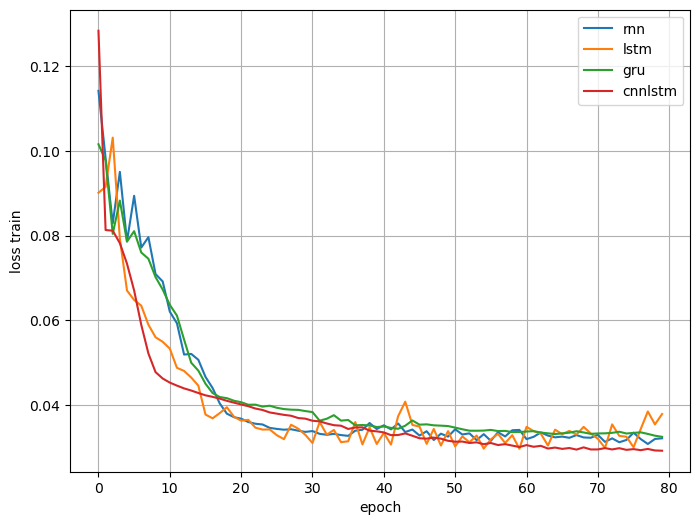

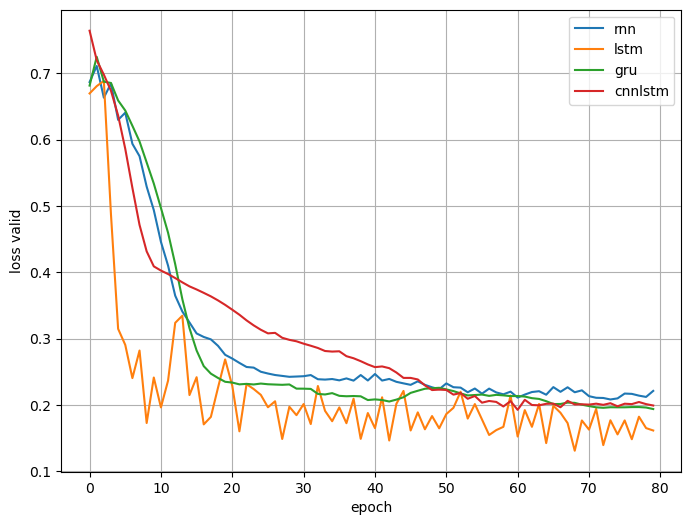

In [58]:
def plot_lcs(x:str, y:str):
  plt.figure(figsize=(8, 6))
  #
  for model in ['rnn', 'lstm', 'gru', 'cnnlstm']:
    z = torch.load(f'./model/{model}-{x}-{y}.pt')
    #
    plt.plot(range(num_epochs), z, label=model)
    plt.xlabel('epoch')
    plt.ylabel(f'{x} {y}')
    plt.grid(True)
    plt.legend()

plot_lcs('loss', 'train')
plot_lcs('loss', 'valid')

## MAE Score for All Models

creat table and write MAE Values for all Models

In [59]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [60]:
pred_dataset = x_test
mae_table = PrettyTable(["Model", "RNN", "LSTM", "GRU", "CNN-LSTM"])
MAX = y_max.item()

with torch.no_grad():
    mae = []

    for RNN in ['rnn', 'lstm', 'gru', 'cnnlstm']:

      x_test = x_test.to(device)
      model = torch.load(f'./model/{RNN}-model.pt')
      pred = model(x_test).to(device)
      mae.append(MAE(np.array(y_test) * MAX, np.array(pred.cpu()) * MAX))

    mae_table.add_row(['MAE', mae[0], mae[1], mae[2], mae[3]])

### Make Table

In [61]:
print(mae_table)

+-------+-----------+---------+-----------+------------+
| Model |    RNN    |   LSTM  |    GRU    |  CNN-LSTM  |
+-------+-----------+---------+-----------+------------+
|  MAE  | 143.99677 | 97.5025 | 141.40483 | 123.353615 |
+-------+-----------+---------+-----------+------------+


# **Prediction🔎**

In [62]:
pred_dataset = x_test
mdl = ['rnn', 'lstm', 'gru', 'cnnlstm']

with torch.no_grad():
    preds = []
    for RNN in ['rnn', 'lstm', 'gru', 'cnnlstm']:

      x_test = x_test.to(device)
      model = torch.load(f'./model/{RNN}-model.pt')
      pred = model(x_test).to(device)
      preds.append(pred.cpu())

## Load daily_cases.csv

In [64]:
daily_cases = pd.read_csv('./data/daily_cases.csv', index_col=0)

## Plot

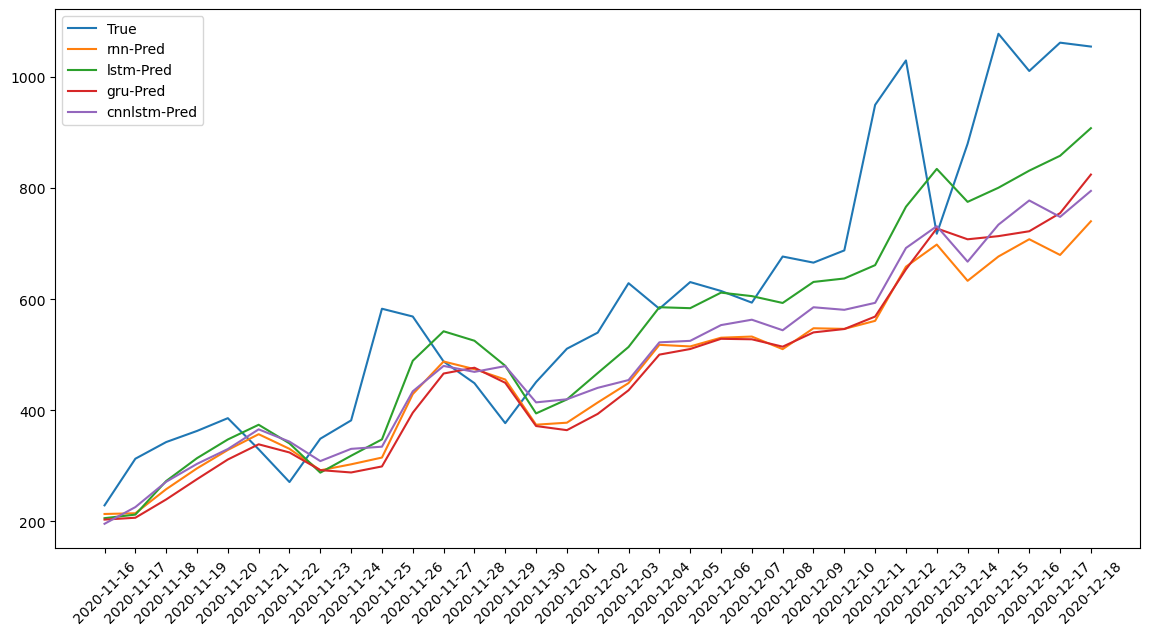

In [65]:
plt.figure(figsize=(14, 7))
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * y_max.item(), label='True')
plt.plot(daily_cases.index[-len(pred):], np.array(preds[0]) * y_max.item(), label='rnn-Pred')
plt.plot(daily_cases.index[-len(pred):], np.array(preds[1]) * y_max.item(), label='lstm-Pred')
plt.plot(daily_cases.index[-len(pred):], np.array(preds[2]) * y_max.item(), label='gru-Pred')
plt.plot(daily_cases.index[-len(pred):], np.array(preds[3]) * y_max.item(), label='cnnlstm-Pred')
plt.xticks(rotation=45)
plt.legend()

# **Bonus🌟**

In [66]:
df = pd.read_csv('./data/daily_cases.csv', index_col=0)

In [67]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):

        xs.append(data.iloc[i: (i + seq_length)])
        ys.append(data.iloc[i + seq_length])

    return np.array(xs), np.array(ys)

In [68]:
seq_length = 5
x, y = create_sequences(df, seq_length)
print(x.shape)
print(y.shape)

(327, 5, 1)
(327, 1)
